# Multi-Armed Bandit for Data Selection

We follow in the footsteps of Gutiérrez et al (2017). Let us first formulate our objective mathematically.

#### Modelling Objective

We want to model $f: (x, \mathbf{p}) \mapsto y$, where $f$ belongs to the class of linear regression estimators parameterized by vector $\mathbf{p}$. $x_i$  and $y_i$ are the RH98 and AGBD of footprint $i$, respectively. 

Parameters $\mathbf{p}$ are estimated using a training set $S^T = \{ s_1, \ldots, s_{N_{\text{train}}} \}$ consisting of samples $s = (x,y)$. However, $S^T$ is merely a subsample from the available training data $S = \{ h_1, \ldots, h_{N_{\text{total}}} \} $ which consists of _hidden_ samples of the form $h = \{ \tilde{x}, \tilde{y}, \mathbf{m} \}$. They are hidden because RH98 $\tilde{x}$ and AGBD $\tilde{y}$ are only revealed after the sample is added to the training set. By contrast, metadata $\mathbf{m}$ about the sample is known à priori. To begin with, $S$ consists of all data in Ghana with PFT class = 2. 

#### Sample Efficiency Objective

Unlike Gutiérrez et al, we do not incur a large cost from observing $\tilde{x}$ or $\tilde{y}$. However, we are interested in selecting only the most relevant samples according to $\mathbf{m}$ all the same. We will later generalise our method to larger, more complicated datasets and more sophisticated model classes, hence sample efficiency will be important to minimise the computational burden of training the model.

We select samples by partitioning $S$ into a pre-defined number of bins $\eta_j$ for select $m_j$ $(1 \leq j \leq d)$ in $\mathbf{m}$. For instance, if $m_j$ is a categorical variable with four categories, we create the j'th partition $S = \bigcup_{k=1}^{4} C_k^j$, where $C_1^j$ contains all samples where $m_j$ is in class 1, $C_2^j$ contains all samples where $m_j$ is in class 2, etc. If $m_j$ is continuous, we quantize the variable into bins and partition accordingly. All the clusters generated using different meta information are then merged into a set of clusters $\mathcal{C} = \{C_l^j\}$. Our hypothesis is that some clusters $C_i \in \mathcal{C}$ contain more relevant information for the modelling task than others, but we do not know which. This motivates us to train a multi-armed bandit who will simultaneously _explore_ the clusters to find out which contain the most relevant information and eventually _exploit_ these clusters to maximise the share of data therefrom.

The multi-armed bandit algorithm is described in detail in their paper, but to summarise:

* At every time $t$:
    * Sample the probability of reward $\hat{\pi}_i$ from $Beta(\alpha_i, \beta_i)$ for every cluster
    * Pick a datapoint $s$ from the cluster with highest probability of reward
    * Add $s$ to $S^T$ and re-train the model
    * Predict $\hat{y}$ for a holdout validation set
    * If score increases (decreases), $r_t = 1 \ (-1)$
    * Update $\alpha_i, \beta_i$ based on $r_t$ 

#### Summary of Objective

Our dual objectives are then:

1) To optimize the performance of $f$ at predicting $y$, as measured by the MAPE on a holdout test set.
2) To include as few samples as necessary in $S^T$.

We will train a multi-armed bandit data selector to achieve both in parallel.

### Load Packages and Data

In [1]:
import pandas as pd
import geopandas as gpd
import pyogrio
import os
import pandas.api.types as ptypes
import numpy as np
import warnings
import pickle as pkl
import types
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error, r2_score, explained_variance_score, mean_squared_error # , root_mean_squared_error
from matplotlib import pyplot as plt
from scipy.stats import beta

# import bandit(s)
from MABS import bandit, crafty_bandit, lazy_bandit, ND_bandit

# import score functions
from custom_score_functions import log_ratio

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis")

Load `df_ghana`

In [4]:
dtypes = {
     'pft_class': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'selected_a': 'category'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'geometry': 'object'
}

df_ghana = pd.read_csv("df_ghana.csv", dtype=dtypes)

# PREDICTING AGBD FROM SATELLITE BAND DATA

Load features and labels

In [7]:
suffix          = "_2020-vghana.csv"

test_features   = pd.read_csv("test_features" + suffix)
test_labels     = pd.read_csv("test_labels" + suffix)
train_features  = pd.read_csv("train_features" + suffix)
train_labels    = pd.read_csv("train_labels" + suffix)
val_features    = pd.read_csv("val_features" + suffix)
val_labels      = pd.read_csv("val_labels" + suffix)

Merge into one dataset

In [16]:
test_features['agbd']           = test_labels['agbd']
train_features['agbd']          = train_labels['agbd']
val_features['agbd']            = val_labels['agbd']

test_features['identity']       = 'test'
train_features['identity']      = 'train'
val_features['identity']        = 'val'

df_satellite_band               = pd.concat([train_features, val_features, test_features], ignore_index=True)
# df_satellite_band.to_csv("df_satellite_band.csv", index=False)

Set column types and load data

In [2]:
column_types = {
    "B01": "float64",
    "B02": "float64",
    "B03": "float64",
    "B04": "float64",
    "B05": "float64",
    "B06": "float64",
    "B07": "float64",
    "B08": "float64",
    "B8A": "float64",
    "B09": "float64",
    "B11": "float64",
    "B12": "float64",
    "lat_cos": "float64",
    "lat_sin": "float64",
    "lon_cos": "float64",
    "lon_sin": "float64",
    "gedi_num_days": "float64",
    "gedi_doy_cos": "float64",
    "gedi_doy_sin": "float64",
    "agbd_se": "float64",
    "elev_lowes": "float64",
    "pft_class": "category",
    "region_cla": "category",
    "rh98": "float64",
    "selected_a": "category",
    "sensitivit": "float64",
    "solar_elev": "float64",
    "urban_prop": "float64",
    "alos_hh": "float64",
    "alos_hv": "float64",
    "ch": "float64",
    "ch_std": "float64",
    "lc_cos": "float64",
    "lc_sin": "float64",
    "lc_prob": "float64",
    "dem": "float64",
    "agbd": "float64",
    "identity": "category"
}

df_satellite_band = pd.read_csv("df_satellite_band.csv", dtype=column_types)
# df_satellite_band = df_satellite_band.astype(column_types)

Instantiate bandit

In [3]:
hidden_indices          = df_satellite_band[df_satellite_band['identity'] == 'train'].index.tolist()
val_indices             = df_satellite_band[df_satellite_band['identity'] == 'val'].index.tolist()
test_indices            = df_satellite_band[df_satellite_band['identity'] == 'test'].index.tolist()

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':8, 'ch':8}
T                       = 4000
batch_size              = 1
test_freq               = 50

bandit_satellite        = lazy_bandit(df_satellite_band, x=x, y=y, features=features
                                      , hidden_indices=hidden_indices, test_indices=test_indices, val_indices=val_indices
                                      , T=T, batch_size=batch_size, test_freq=test_freq)

Benchmarking run 1 for model rb


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 1 for model MABS


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 1 for model full


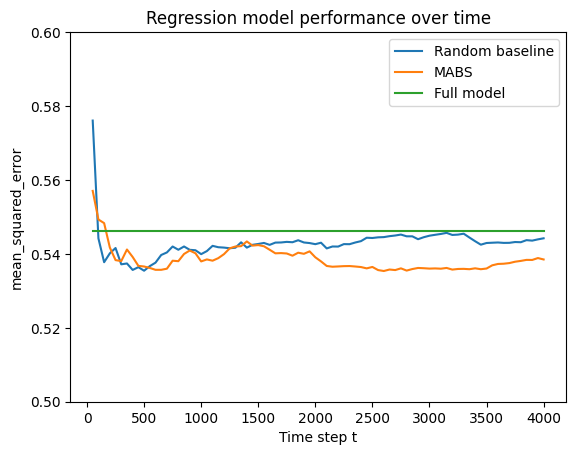

In [5]:
bandit_satellite.reset()
bandit_satellite.benchmark_MABS(n_runs=1)

After 4,000 iterations, it does genuinely look like MABS is out-performing the baselines! Lucky? Let's reduce the Y axis for ease and re-do.

Now we try an `ND_bandit()`

In [12]:
bandit_satellite.dataset['alos_hh']

0         0.677691
1         0.689002
2         0.619217
3         0.611538
4         0.595189
            ...   
390941    0.762419
390942    0.623909
390943    0.654469
390944    0.754955
390945    0.721086
Name: alos_hh, Length: 390946, dtype: float64

In [3]:
hidden_indices          = df_satellite_band[df_satellite_band['identity'] == 'train'].index.tolist()
val_indices             = df_satellite_band[df_satellite_band['identity'] == 'val'].index.tolist()
test_indices            = df_satellite_band[df_satellite_band['identity'] == 'test'].index.tolist()

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'alos_hh':3}
T                       = 4000
batch_size              = 1
test_freq               = 50

bandit_satellite        = ND_bandit(df_satellite_band, x=x, y=y, features=features
                                      , hidden_indices=hidden_indices, test_indices=test_indices, val_indices=val_indices
                                      , T=T, batch_size=batch_size, test_freq=test_freq)

bandit_satellite.score  = log_ratio

In [4]:
bandit_satellite.benchmark_MABS(n_runs=5)

Benchmarking run 1 for model full
Benchmarking run 1 for model rb
Benchmarking run 2 for model rb
Benchmarking run 3 for model rb
Benchmarking run 4 for model rb
Benchmarking run 5 for model rb
Benchmarking run 1 for model MABS


: 

With MSE, all the error scores are very high! MSE = 3600 for the full model corresponds to errors around 63.

In [38]:
df_test         = df_satellite_band[df_satellite_band['identity'] == 'test']
df_train        = df_satellite_band[df_satellite_band['identity'] == 'train']
df_val          = df_satellite_band[df_satellite_band['identity'] == 'val']

mean_str        = "Mean of agbd in {} data is {}"

print(mean_str.format("train", round(np.mean(df_train['agbd']), 2)))
print(mean_str.format("test", round(np.mean(df_test['agbd']),2)))
print(mean_str.format("validation", round(np.mean(df_val['agbd']),2)))

Mean of agbd in train data is 25.47
Mean of agbd in test data is 44.89
Mean of agbd in validation data is 33.38


In [41]:
hidden_indices          = df_satellite_band[df_satellite_band['identity'] == 'train'].index.tolist()
val_indices             = df_satellite_band[df_satellite_band['identity'] == 'val'].index.tolist()
test_indices            = df_satellite_band[df_satellite_band['identity'] == 'test'].index.tolist()

x                       = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
y                       = 'agbd'
features                = {'pft_class':None, 'sensitivit':3, 'alos_hh':3}
T                       = 4000
batch_size              = 1
test_freq               = 50

bandit_satellite        = ND_bandit(df_satellite_band, x=x, y=y, features=features
                                      , hidden_indices=hidden_indices, test_indices=test_indices, val_indices=val_indices
                                      , T=T, batch_size=batch_size, test_freq=test_freq)

bandit_satellite.score  = log_ratio

In [43]:
bandit_satellite.lower_is_better

True

In [44]:
bandit_satellite.benchmark_MABS(5)

Benchmarking run 1 for model rb


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 2 for model rb


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 3 for model rb


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 4 for model rb


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5 for model rb


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


KeyboardInterrupt: 

In [8]:
df_satellite_band.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'lat_cos', 'lat_sin', 'lon_cos', 'lon_sin',
       'gedi_num_days', 'gedi_doy_cos', 'gedi_doy_sin', 'agbd_se',
       'elev_lowes', 'pft_class', 'region_cla', 'rh98', 'selected_a',
       'sensitivit', 'solar_elev', 'urban_prop', 'alos_hh', 'alos_hv', 'ch',
       'ch_std', 'lc_cos', 'lc_sin', 'lc_prob', 'dem', 'agbd', 'identity'],
      dtype='object')

# -------------- DECOMISSIONED CODE --------------

### Test the agent on `df_ghana`

Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 1


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 2


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 3


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


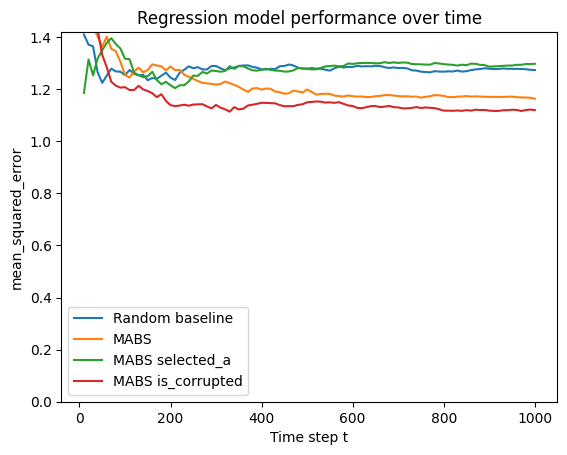

In [69]:
features_ghana  = {'selected_a':None}
x               = 'rh98'
y               = 'agbd'

crafty_boi = crafty_bandit(df_ghana, x=x\
                , y=y, features=features_ghana, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

crafty_boi.benchmark_MABS(5)

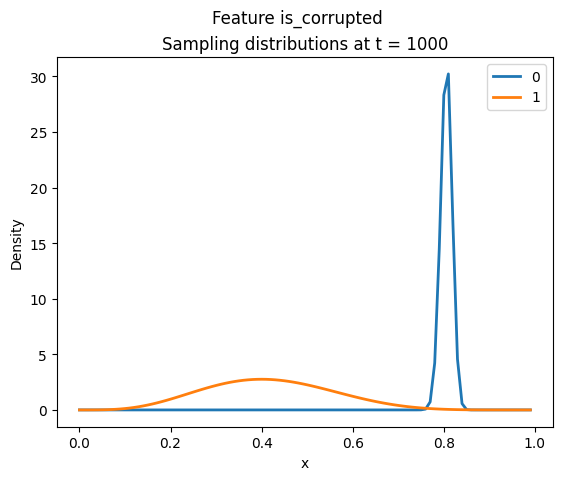

In [70]:
crafty_boi.plot_beta_dist('is_corrupted')

Summary: the agent performs as well as randomly selecting datapoints for the features tested. This is hardly surprising though. In simple linear regression, the model class considered is small.

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_boi = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_boi.benchmark_MABS(n_runs=10)

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_gal = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_gal.benchmark_MABS(n_runs=3)

In [ ]:
test_list = [x for x in range(51)]
test_list[10::10]

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_kid = bandit(df_ghana, x="rh98", y="agbd", features=features, T=50, batch_size=1)
bandit_kid.benchmark_MABS(n_runs=1)

Load previous bandit

In [ ]:
with open('bandit_boi.pkl', 'rb') as file:
    bandit_boi = pkl.load(file)

### Test the agent on `Appliances Energy Prediction`

We will test the agent on another dataset, `Appliances Energy Production`. The dataset consists of 19,000 measurements of household energy consumption, temperature and humidity conditions, co-located with meteorological variables. Our objective is to predict energy usage given the environmental variables.


In [ ]:
def get_df_energy():
    """
    Quick function to load & preprocess the appliances energy data.
    """
    # fetch dataset 
    appliances_energy_prediction = fetch_ucirepo(id=374)
    df_energy = appliances_energy_prediction.data['original']

    df_energy['date']       = pd.to_datetime(df_energy['date'], format='%Y-%m-%d%H:%M:%S')
    df_energy['month']      = df_energy['date'].dt.month
    # df_energy['month']      = df_energy['month'].astype('category')
    df_energy['lights']     = df_energy['lights'].astype('category')

    # difference between outside and inside temperature is a relevant variable

    df_energy['T_inside']   = df_energy.apply(lambda row: np.mean([row['T1'], row['T2'], row['T3'], row['T4'],\
                                                                   row['T5'], row['T7'], row['T8'], row['T9']])\
                                                                   , axis=1)

    df_energy['heating']    = df_energy['T_inside'] - df_energy['T6']

    df_energy['humid_in']   = df_energy.apply(lambda row: np.mean([row['RH_1'], row['RH_2'], row['RH_3'], row['RH_4'],\
                                                                   row['RH_5'], row['RH_7'], row['RH_8'], row['RH_9']])\
                                                                   , axis=1)

    df_energy['humid_diff'] = df_energy['humid_in'] - df_energy['RH_6']

    return df_energy

In [ ]:
df_energy = get_df_energy()
df_energy.columns

Column `Appliances` is the response variable (energy use in Wh). `TX` and `RHX` are temperature and relative humidity metrics for room `X`, respectively, while `lights` is the energy use of light fixtures in the house (Wh). The rest of the variables are meteorological measurements from a nearby weather station. A priori, I would expect that the `lights` variable is relevant for determining clusters, while `T_out` is a relevant predictor. 

In [ ]:
features_energy = {'month':None}

bandit_energy   = bandit(df_energy, x=['heating', 'lights', 'Press_mm_hg', 'humid_diff', 'Windspeed', 'Visibility', 'Tdewpoint']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

We model the appliances energy consumption using temperatures from most rooms and the relative humidity in the bathroom.

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

Perhaps picking observations based on the month in which they are made is not a useful strategy...

In [ ]:
features_energy = {'lights':None}

bandit_energy   = bandit(df_energy, x=['heating', 'humid_diff']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

What is R2 with model for heating and lights, no selection?

In [ ]:
appliances_energy_prediction = fetch_ucirepo(id=374)
df_orig = appliances_energy_prediction.data['original']

In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.fit(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]], df_orig['Appliances'])

In [ ]:
y_pred = linear_model.predict(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]])
r2      = r2_score(df_orig['Appliances'], y_pred)
var_exp = explained_variance_score(df_orig['Appliances'], y_pred)
r2, var_exp

With all predictors and whole dataset, $R^2 = 0.16$, suggesting that this prediction task may be too difficult for separating good and bad models :/

### Data Loading

Manually set `dtypes`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'region_cla': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'elev_lowes': 'float64'
    ,'lat_lowest': 'float64'
    ,'lon_lowest': 'float64'
    ,'selected_a': 'category'
    ,'shot_numbe': 'int64'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'pattern': 'object'
    ,'doy_sin': 'float64'
    ,'doy_cos': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'pft_class_group': 'category'
    ,'geometry': 'object'
}

df_ghana_subsample = pd.read_csv('df_ghana_subsample.csv', dtype=dtypes)

Save `df_ghana`

In [ ]:
df_ghana = gpd.read_file("GEDI_Ghana.geojson"
                         , driver = 'GeoJSON'
                         , engine='pyogrio')

df_ghana = df_ghana[df_ghana['pft_class'] == 2]

cols_to_keep = ['pft_class', 'leaf_off_f','urban_prop','agbd','agbd_se', 'beam', 'selected_a', 'sensitivit'\
                     , 'solar_elev', 'rh98', 'date', 'lat_cos','lat_sin','lon_cos','lon_sin', 'geometry']

df_ghana = df_ghana[cols_to_keep]

df_ghana.to_csv("df_ghana.csv", index=False)

df_ghana.head(5)

### Test the agent on `Bike Sharing Data`

We have 17379 observations corresponding to hourly measurements of weather and a variable `cnt` indicating the number of bikes rented.

In [ ]:
def classify_day(row):
    """
    Simplify classification of DOTW
    """
    if row['holiday'] == 1: return 'holiday'
    elif row['weekday'] in [0,6]: return 'weekend'
    else: return 'work day'

In [ ]:
def classify_hr(row):
    """
    Simplify classification of hr
    """
    if row['hr'] in [8,16,17,18,19]: return 'rush hour'
    elif row['hr'] in [7, 9, 10, 11, 12, 13, 14, 15, 20]: return 'day'
    else: return 'night'

In [ ]:
def get_df_bike():
    """
    Wrapper to fetch and preprocess the bike sharing data.
    """
    bike                = fetch_ucirepo(id=275)
    df_bike             = bike.data['original']

    # simplify classificaitons
    df_bike['day_type'] = df_bike.apply(lambda row: classify_day(row), axis=1)
    df_bike['hr_type']  = df_bike.apply(lambda row: classify_hr(row), axis=1)

    # cat cols
    cat_cols            = ['day_type', 'hr_type', 'season', 'weathersit']
    df_bike[cat_cols]   = df_bike[cat_cols].astype('category')
    
    # drop redundant columns
    df_bike.drop(columns=['casual', 'registered', 'temp', 'holiday', 'weekday', 'workingday', 'hr', 'mnth', 'dteday', 'instant'], inplace=True)

    return df_bike, cat_cols

In [ ]:
average_cnt_by_hr = df_bike.groupby('hr')['cnt'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_cnt_by_hr.index, average_cnt_by_hr.values, marker='o', linestyle='-', color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.title('Average Count by Hour of the Day')
plt.grid(True)
plt.xticks(range(24))  # Assuming hr is in 24-hour format
plt.show()

In [ ]:
df_encoded.head()

In [ ]:
df_bike.head()

In [ ]:
df_bike, cat_cols = get_df_bike()
df_encoded        = pd.get_dummies(df_bike, columns=['season', 'yr', 'weathersit'], drop_first=True)

bike_features = {'day_type': None, 'hr_type': None}
x             = [col for col in df_encoded.columns if col not in ['cnt', 'day_type', 'hr_type']]


# bandit_bike = bandit(df_encoded, x=x\
#                , y='cnt', features= bike_features, T=1000, batch_size=1\
#                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10)

crafty_bandit_bike = crafty_bandit(df_encoded, x=x\
                , y='cnt', features= bike_features, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

In [ ]:
crafty_bandit_bike.features

In [ ]:
crafty_bandit_bike.benchmark_MABS(n_runs=3)

In [ ]:
crafty_bandit_bike.plot_beta_dist('is_corrupted')

In [ ]:
bandit_bike.benchmark_MABS(n_runs=10)

In [ ]:
len(y_hat)

In [ ]:
y       = np.array([3, 3])
y_hat   = np.array([6, 7])

mean_absolute_percentage_error(y, y_hat)

In [ ]:
bandit_mse.reset()
bandit_mse.benchmark_MABS(n_runs=10)

In [ ]:
bandit_UTH.reset()
bandit_UTH.benchmark_MABS(n_runs=10)

In [ ]:
len(bandit_UTH.test_scores)

In [ ]:
bandit_UTH.plot_beta_dist('day_type')

In [ ]:
# LASSO
bike_bandit.benchmark_MABS(n_runs=10)

In [ ]:
# RIDGE

bike_bandit.benchmark_MABS(n_runs=10)